In [1]:
import pandas as pd
import requests
import glob
import time
import os, sys
import numpy as np
from matplotlib import pyplot as plt
import traceback

import requests
import shutil
import time
from urllib.parse import urlparse

In [2]:
task = pd.read_csv("data/task.csv")
task

,index,task_type,prompt,ori_image,target_image
0,1,t2i,一棵令人惊叹的树从太空中的一颗小行星上生长出来，细节复杂，自然光线照射，呈现出超现实的3D渲...,NaN,NaN
1,2,t2i,宁静的天空中，以概念艺术风格绘制的平和蓬松的云朵，分辨率为4K。,NaN,NaN
2,3,t2i,一张逼真的照片，展示了一位皮肤光滑的男性机器人，它像雕像一样在工厂中摆出姿势。,NaN,NaN
3,4,t2i,这是一幅以平滑的数字肖像插画概念艺术风格描绘的身穿宇航服的年轻宇航员。,NaN,NaN
4,5,t2i,A vibrant cityscape at dawn with sharp focus a...,NaN,NaN
...,...,...,...,...,...
995,996,deepfake,NaN,4c234474342546df9034a19dbb230bed.jpg,627b2ac2e0194fc89c015c769decfe6d.jpg
996,997,deepfake,NaN,0aa8cb980be845a4a30b2248f9abe226.jpg,4d00dbabc9ff47fcba54c21d64bcc458.jpg
997,998,deepfake,NaN,a701aec125ce459b9cff76eadd7e0263.jpg,2b8c21b179ec4c1187d60682f7fca808.jpg
998,999,deepfake,NaN,70eff544233242dab682d2d209fcc2e3.jpg,77932521bc3c440eba39c34eafcdee25.jpg


# 将下述指令复制到终端运行，即可下载模型
modelscope download --model 'ZhipuAI/CogView4-6B' --local_dir '/root/autodl-tmp/ZhipuAI/CogView4-6B'

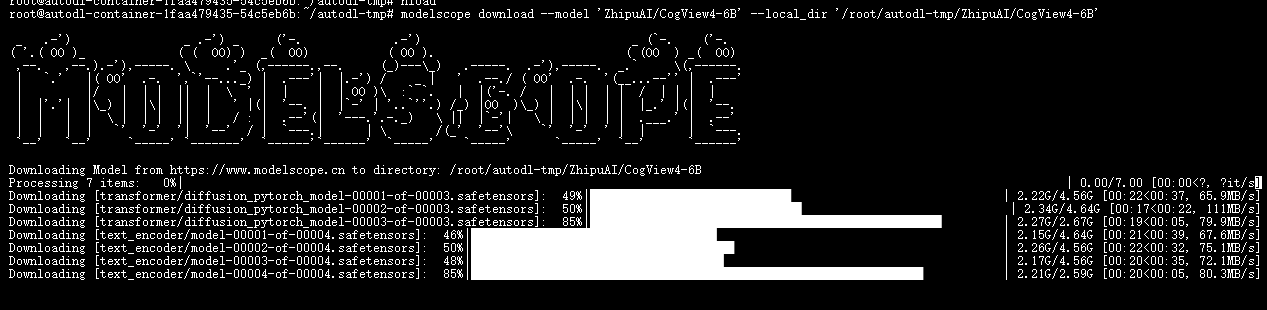

In [4]:
from diffusers import CogView4Pipeline
import torch

pipe = CogView4Pipeline.from_pretrained("/root/autodl-tmp/ZhipuAI/CogView4-6B", torch_dtype=torch.bfloat16)
pipe.enable_model_cpu_offload()
pipe.vae.enable_slicing()
pipe.vae.enable_tiling()

prompt = "A vibrant cherry red sports car sits proudly under the gleaming sun, its polished exterior smooth and flawless, casting a mirror-like reflection. The car features a low, aerodynamic body, angular headlights that gaze forward like predatory eyes, and a set of black, high-gloss racing rims that contrast starkly with the red. A subtle hint of chrome embellishes the grille and exhaust, while the tinted windows suggest a luxurious and private interior. The scene conveys a sense of speed and elegance, the car appearing as if it's about to burst into a sprint along a coastal road, with the ocean's azure waves crashing in the background."
image = pipe(
    prompt=prompt,
    guidance_scale=3.5,
    num_images_per_prompt=1,
    num_inference_steps=50,
    width=512,
    height=512,
).images[0]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [5]:
# 第四个 task deepfake部分需要
# pip install opencv-python dlib

# 需要下载 并解压 https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
# wget https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
# bzip2 -d shape_predictor_68_face_landmarks.dat.bz2
try:
    import cv2
    import dlib
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("./shape_predictor_68_face_landmarks.dat")
except:
    traceback.print_exc()
    pass
    
def face_swap_using_dlib(source_img_path: str, aim_img_path: str, save_img_path: str):
    face = cv2.imread(source_img_path)
    body = cv2.imread(aim_img_path)

    face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
    body_gray = cv2.cvtColor(body, cv2.COLOR_BGR2GRAY)
    
    # Create empty matrices in the images' shapes
    height, width = face_gray.shape
    mask = np.zeros((height, width), np.uint8)
    
    height, width, channels = body.shape

    rect = detector(face_gray)[0]
    
    # This creates a with 68 pairs of integer values — these values are the (x, y)-coordinates of the facial structures 
    landmarks = predictor(face_gray, rect)
    landmarks_points = [] 
    
    def get_landmarks(landmarks, landmarks_points):
      for n in range(68):
          x = landmarks.part(n).x
          y = landmarks.part(n).y
          landmarks_points.append((x, y))
    
    get_landmarks(landmarks, landmarks_points)
    
    points = np.array(landmarks_points, np.int32)


    convexhull = cv2.convexHull(points) 
    face_cp = face.copy()
    face_image_1 = cv2.bitwise_and(face, face, mask=mask)


    rect = cv2.boundingRect(convexhull)
    
    subdiv = cv2.Subdiv2D(rect) # Creates an instance of Subdiv2D
    subdiv.insert(landmarks_points) # Insert points into subdiv
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, dtype=np.int32)
    
    indexes_triangles = []
    face_cp = face.copy()
    
    def get_index(arr):
        index = 0
        if arr[0]:
            index = arr[0][0]
        return index
    
    for triangle in triangles :
    
        # Gets the vertex of the triangle
        pt1 = (triangle[0], triangle[1])
        pt2 = (triangle[2], triangle[3])
        pt3 = (triangle[4], triangle[5])
        
        # Draws a line for each side of the triangle
        cv2.line(face_cp, pt1, pt2, (255, 255, 255), 3,  0)
        cv2.line(face_cp, pt2, pt3, (255, 255, 255), 3,  0)
        cv2.line(face_cp, pt3, pt1, (255, 255, 255), 3,  0)
    
        index_pt1 = np.where((points == pt1).all(axis=1))
        index_pt1 = get_index(index_pt1)
        index_pt2 = np.where((points == pt2).all(axis=1))
        index_pt2 = get_index(index_pt2)
        index_pt3 = np.where((points == pt3).all(axis=1))
        index_pt3 = get_index(index_pt3)
    
        # Saves coordinates if the triangle exists and has 3 vertices
        if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
            vertices = [index_pt1, index_pt2, index_pt3]
            indexes_triangles.append(vertices)

    # Getting landmarks for the face that will have the first one swapped into
    rect2 = detector(body_gray)[0]
    
    # This creates a with 68 pairs of integer values — these values are the (x, y)-coordinates of the facial structures 
    landmarks_2 = predictor(body_gray, rect2)
    landmarks_points2 = []
    
    # Uses the function declared previously to get a list of the landmark coordinates
    get_landmarks(landmarks_2, landmarks_points2)
    
    # Generates a convex hull for the second person
    points2 = np.array(landmarks_points2, np.int32)
    convexhull2 = cv2.convexHull(points2)
    
    body_cp = body.copy()


    lines_space_new_face = np.zeros((height, width, channels), np.uint8)
    body_new_face = np.zeros((height, width, channels), np.uint8)
    
    height, width = face_gray.shape
    lines_space_mask = np.zeros((height, width), np.uint8)
    
    
    for triangle in indexes_triangles:
    
        # Coordinates of the first person's delaunay triangles
        pt1 = landmarks_points[triangle[0]]
        pt2 = landmarks_points[triangle[1]]
        pt3 = landmarks_points[triangle[2]]
    
        # Gets the delaunay triangles
        (x, y, widht, height) = cv2.boundingRect(np.array([pt1, pt2, pt3], np.int32))
        cropped_triangle = face[y: y+height, x: x+widht]
        cropped_mask = np.zeros((height, widht), np.uint8)
    
        # Fills triangle to generate the mask
        points = np.array([[pt1[0]-x, pt1[1]-y], [pt2[0]-x, pt2[1]-y], [pt3[0]-x, pt3[1]-y]], np.int32)
        cv2.fillConvexPoly(cropped_mask, points, 255)
    
        # Draws lines for the triangles
        cv2.line(lines_space_mask, pt1, pt2, 255)
        cv2.line(lines_space_mask, pt2, pt3, 255)
        cv2.line(lines_space_mask, pt1, pt3, 255)
    
        lines_space = cv2.bitwise_and(face, face, mask=lines_space_mask)
    
        # Calculates the delaunay triangles of the second person's face
    
        # Coordinates of the first person's delaunay triangles
        pt1 = landmarks_points2[triangle[0]]
        pt2 = landmarks_points2[triangle[1]]
        pt3 = landmarks_points2[triangle[2]]
    
        # Gets the delaunay triangles
        (x, y, widht, height) = cv2.boundingRect(np.array([pt1, pt2, pt3], np.int32))
        cropped_mask2 = np.zeros((height,widht), np.uint8)
    
        # Fills triangle to generate the mask
        points2 = np.array([[pt1[0]-x, pt1[1]-y], [pt2[0]-x, pt2[1]-y], [pt3[0]-x, pt3[1]-y]], np.int32)
        cv2.fillConvexPoly(cropped_mask2, points2, 255)
    
        # Deforms the triangles to fit the subject's face : https://docs.opencv.org/3.4/d4/d61/tutorial_warp_affine.html
        points =  np.float32(points)
        points2 = np.float32(points2)
        M = cv2.getAffineTransform(points, points2)  # Warps the content of the first triangle to fit in the second one
        dist_triangle = cv2.warpAffine(cropped_triangle, M, (widht, height))
        dist_triangle = cv2.bitwise_and(dist_triangle, dist_triangle, mask=cropped_mask2)
    
        # Joins all the distorted triangles to make the face mask to fit in the second person's features
        body_new_face_rect_area = body_new_face[y: y+height, x: x+widht]
        body_new_face_rect_area_gray = cv2.cvtColor(body_new_face_rect_area, cv2.COLOR_BGR2GRAY)
    
        # Creates a mask
        masked_triangle = cv2.threshold(body_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
        dist_triangle = cv2.bitwise_and(dist_triangle, dist_triangle, mask=masked_triangle[1])
    
        # Adds the piece to the face mask
        body_new_face_rect_area = cv2.add(body_new_face_rect_area, dist_triangle)
        body_new_face[y: y+height, x: x+widht] = body_new_face_rect_area

    body_face_mask = np.zeros_like(body_gray)
    body_head_mask = cv2.fillConvexPoly(body_face_mask, convexhull2, 255)
    body_face_mask = cv2.bitwise_not(body_head_mask)
    
    body_maskless = cv2.bitwise_and(body, body, mask=body_face_mask)
    result = cv2.add(body_maskless, body_new_face)

    # Gets the center of the face for the body
    (x, y, widht, height) = cv2.boundingRect(convexhull2)
    center_face2 = (int((x+x+widht)/2), int((y+y+height)/2))
    
    seamlessclone = cv2.seamlessClone(result, body, body_head_mask, center_face2, cv2.NORMAL_CLONE)    
    cv2.imwrite(save_img_path, seamlessclone)

In [6]:
os.makedirs("imgs", exist_ok=True)

In [7]:
task

,index,task_type,prompt,ori_image,target_image
0,1,t2i,一棵令人惊叹的树从太空中的一颗小行星上生长出来，细节复杂，自然光线照射，呈现出超现实的3D渲...,NaN,NaN
1,2,t2i,宁静的天空中，以概念艺术风格绘制的平和蓬松的云朵，分辨率为4K。,NaN,NaN
2,3,t2i,一张逼真的照片，展示了一位皮肤光滑的男性机器人，它像雕像一样在工厂中摆出姿势。,NaN,NaN
3,4,t2i,这是一幅以平滑的数字肖像插画概念艺术风格描绘的身穿宇航服的年轻宇航员。,NaN,NaN
4,5,t2i,A vibrant cityscape at dawn with sharp focus a...,NaN,NaN
...,...,...,...,...,...
995,996,deepfake,NaN,4c234474342546df9034a19dbb230bed.jpg,627b2ac2e0194fc89c015c769decfe6d.jpg
996,997,deepfake,NaN,0aa8cb980be845a4a30b2248f9abe226.jpg,4d00dbabc9ff47fcba54c21d64bcc458.jpg
997,998,deepfake,NaN,a701aec125ce459b9cff76eadd7e0263.jpg,2b8c21b179ec4c1187d60682f7fca808.jpg
998,999,deepfake,NaN,70eff544233242dab682d2d209fcc2e3.jpg,77932521bc3c440eba39c34eafcdee25.jpg


In [8]:
for row in task.iterrows():
    # if os.path.exists("imgs/" + str(row[1]['index']) + ".jpg"):
    #     continue

    if row[1].task_type == "t2i":
        if row[1]["index"] < 10: # 只生成前10个图片，全部生成会比较慢的
            image = pipe(
                prompt=row[1].prompt,
                guidance_scale=3.5,
                num_images_per_prompt=1,
                num_inference_steps=50,
                width=512,
                height=512,
            ).images[0]
            image.save("./imgs/" + str(row[1]['index']) + ".jpg")


    # 这2个暂时不跑
    if row[1].task_type == "tie":
        # 可单独使用如下模型
        # https://huggingface.co/black-forest-labs/FLUX.1-Kontext-dev
        pass
    if row[1].task_type == "vttie":
        # 可单独使用如下模型
        # https://huggingface.co/black-forest-labs/FLUX.1-Kontext-dev
        pass
    
    if row[1].task_type == "deepfake":
        try:
            # 不一定能换脸成功，失败就跳过
            face_swap_using_dlib(
                "./data/imgs/" + row[1]['ori_image'], 
                "./data/imgs/" + row[1]['target_image'],
                "./imgs/" + str(row[1]['index']) + ".jpg"
            )
        except:
            traceback.print_exc()
            pass

    if not os.path.exists("./imgs/" + str(row[1]['index']) + ".jpg"):
        # 把没有生成的/生成失败的找个照片来凑数，确保能提交
        shutil.copy("./data/imgs/00477d219d8d480fa78380405b0e7480.jpg", "./imgs/" + str(row[1]['index']) + ".jpg")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/tmp/ipykernel_1473/3457059741.py", line 29, in <module>
    face_swap_using_dlib(
  File "/tmp/ipykernel_1473/504579933.py", line 82, in face_swap_using_dlib
    index_pt2 = get_index(index_pt2)
                ^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_1473/504579933.py", line 63, in get_index
    if arr[0]:
       ~~~^^^
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Traceback (most recent call last):
  File "/tmp/ipykernel_1473/3457059741.py", line 29, in <module>
    face_swap_using_dlib(
  File "/tmp/ipykernel_1473/504579933.py", line 82, in face_swap_using_dlib
    index_pt2 = get_index(index_pt2)
                ^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_1473/504579933.py", line 63, in get_index
    if arr[0]:
       ~~~^^^
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Traceback (most recent call last):
  File "/tmp/ipyk

In [9]:
!\rm -rf ./imgs/.ipynb_checkpoints/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [10]:
task["gen_image"] = task["index"].astype(str) + ".jpg"

In [11]:
task[["index", "gen_image"]].to_csv("result.csv", index=None)

In [12]:
!\rm result.zip
!zip -r result.zip result.csv imgs/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


rm: cannot remove 'result.zip': No such file or directory


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: result.csv (deflated 63%)
  adding: imgs/ (stored 0%)
  adding: imgs/1.jpg (deflated 1%)
  adding: imgs/2.jpg (deflated 5%)
  adding: imgs/3.jpg (deflated 1%)
  adding: imgs/4.jpg (deflated 3%)
  adding: imgs/5.jpg (deflated 1%)
  adding: imgs/6.jpg (deflated 1%)
  adding: imgs/7.jpg (deflated 1%)
  adding: imgs/8.jpg (deflated 0%)
  adding: imgs/9.jpg (deflated 0%)
  adding: imgs/10.jpg (deflated 0%)
  adding: imgs/11.jpg (deflated 0%)
  adding: imgs/12.jpg (deflated 0%)
  adding: imgs/13.jpg (deflated 0%)
  adding: imgs/14.jpg (deflated 0%)
  adding: imgs/15.jpg (deflated 0%)
  adding: imgs/16.jpg (deflated 0%)
  adding: imgs/17.jpg (deflated 0%)
  adding: imgs/18.jpg (deflated 0%)
  adding: imgs/19.jpg (deflated 0%)
  adding: imgs/20.jpg (deflated 0%)
  adding: imgs/21.jpg (deflated 0%)
  adding: imgs/22.jpg (deflated 0%)
  adding: imgs/23.jpg (deflated 0%)
  adding: imgs/24.jpg (deflated 0%)
  adding: imgs/25.jpg (deflated 0%)
  adding: imgs/26.jpg (deflated 0%)
  adding:

In [13]:
!ls imgs/ | wc -l

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


1000
